<a href="https://colab.research.google.com/github/fouad6225/projects/blob/main/3d_object_classification_with_deep_learning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 678.6/678.6 KB 18.4 MB/s eta 0:00:00


In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)


In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


473402300/473402300 [==============================] - 12s 0us/step


In [ ]:
trim = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))

samples, fid  = trim.sample(100, return_index=True)
    
    # compute the barycentric coordinates of each sample
bary = trimesh.triangles.points_to_barycentric(
        triangles=trim.triangles[fid], points=samples)
    # interpolate vertex normals from barycentric coordinates
interp = trimesh.unitize((trim.vertex_normals[trim.faces[fid]] *
                              trimesh.unitize(bary).reshape(
                                  (-1, 3, 1))).sum(axis=1))

    
viz = trimesh.load_path(np.column_stack((
        samples, samples + interp)).reshape((-1, 2, 3)))
trimesh.Scene([viz, trim]).show()
print(np.array(viz))

<trimesh.Path3D(vertices.shape=(133, 3), len(entities)=167)>


/root/.keras/datasets/ModelNet10


In [ ]:

xyz = np.zeros((np.size(samples[:,0]), 6))
xyz[:, 0] = np.reshape(samples[:,0], -1)
xyz[:, 1] = np.reshape(samples[:,1], -1)
xyz[:, 2] = np.reshape(samples[:,2], -1)
xyz[:, 3] = np.reshape(interp[:,2], -1)
xyz[:, 4] = np.reshape(interp[:,2], -1)
xyz[:, 5] = np.reshape(interp[:,2], -1)
print('xyz')
print(xyz)
print(np.shape(xyz))

xyz
[[ 9.57798253e+00  6.77056994e+00  1.04216285e+01 -3.12589666e-58
  -3.12589666e-58 -3.12589666e-58]
 [ 3.40427242e+00  1.12098240e+01  1.83588973e+01  2.31083075e-61
   2.31083075e-61  2.31083075e-61]
 [ 9.65667918e+00  4.27126240e+00  4.93759265e+00  3.26496199e-57
   3.26496199e-57  3.26496199e-57]
 [-8.43823385e+00 -4.35000450e+00  6.78708730e-01  8.53459193e-01
   8.53459193e-01  8.53459193e-01]
 [-1.67899780e+00 -1.01766335e+01  6.97012000e-01  8.83741899e-01
   8.83741899e-01  8.83741899e-01]
 [ 6.48991905e+00  8.03438249e+00  1.17359752e+01 -1.74149193e-61
  -1.74149193e-61 -1.74149193e-61]
 [-9.69881898e+00  8.99893004e+00  1.42659718e+01 -2.64016841e-58
  -2.64016841e-58 -2.64016841e-58]
 [-9.69880058e+00  1.93646319e+00  1.62883162e+00 -1.03923176e-56
  -1.03923176e-56 -1.03923176e-56]
 [-4.93254557e+00  1.07354092e+01  1.72863314e+01  1.95387007e-57
   1.95387007e-57  1.95387007e-57]
 [-9.29601997e+00  3.17267646e+00 -8.41600499e-01 -1.78096839e-58
  -1.78096839e-58 -1.

In [ ]:

def Normalize( pointcloud):
        #mean
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        #std
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud
    
def RandomNoise(norm_pointcloud):
    
        #calculate random noise
        noise = np.random.normal(0, 0.02, (norm_pointcloud.shape))
    
        #add noise to points
        noisy_pointcloud = norm_pointcloud + noise
        
        return  noisy_pointcloud
    
    

def RandomScale(noisy_pointcloud):
        s = np.random.uniform(0.9, 1.1, 3)
        
        rot_mat = np.array([[s[0], 0, 0],
                            [0, s[1], 0],
                            [0, 0, s[2]]])
        
        return np.matmul(noisy_pointcloud, rot_mat)

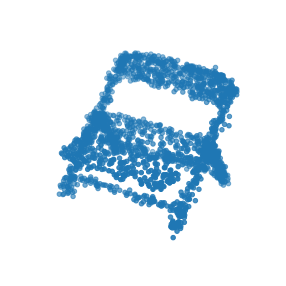

In [ ]:
norm_pointcloud=Normalize(points)
noisy_pointcloud=RandomNoise(norm_pointcloud)
pointcloud=RandomScale(noisy_pointcloud)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pointcloud[:, 0],pointcloud[:, 1], pointcloud[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
import plotly.graph_objects as go
import open3d as o3d
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()
        
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                print("it has normals")
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
                print("it has normals")
            else:
                colors = (1.0, 0.0, 0.0)
            
            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)
        
    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [ ]:
print(np.asarray(downpcd.points[0][0]))

0.19976419928495726


In [ ]:
o3d.visualization.draw_geometries = draw_geometries # replace function
o3d.visualization.draw_geometries([downpcd])


NameError: ignored

In [ ]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            trim=trimesh.load(f)
            
            samples, fid  = trim.sample(2048, return_index=True)
    
    # compute the barycentric coordinates of each sample
            bary = trimesh.triangles.points_to_barycentric(
        triangles=trim.triangles[fid], points=samples)
    # interpolate vertex normals from barycentric coordinates
            interp = trimesh.unitize((trim.vertex_normals[trim.faces[fid]] *
                              trimesh.unitize(bary).reshape(
                                  (-1, 3, 1))).sum(axis=1))
            xyz = np.zeros((np.size(samples[:,0]), 6))
            xyz[:, 0] = np.reshape(samples[:,0], -1)
            xyz[:, 1] = np.reshape(samples[:,1], -1)
            xyz[:, 2] = np.reshape(samples[:,2], -1)
            xyz[:, 3] = np.reshape(interp[:,2], -1)
            xyz[:, 4] = np.reshape(interp[:,2], -1)
            xyz[:, 5] = np.reshape(interp[:,2], -1)
            train_points.append(xyz)
            train_labels.append(i)
        for f in test_files:
            trim1=trimesh.load(f)
            
            samples1, fid1  = trim1.sample(2048, return_index=True)
    
    # compute the barycentric coordinates of each sample
            bary1 = trimesh.triangles.points_to_barycentric(
        triangles=trim1.triangles[fid1], points=samples1)
    # interpolate vertex normals from barycentric coordinates
            interp1 = trimesh.unitize((trim1.vertex_normals[trim1.faces[fid1]] *
                              trimesh.unitize(bary1).reshape(
                                  (-1, 3, 1))).sum(axis=1))
            xyz1 = np.zeros((np.size(samples[:,0]), 6))
            xyz1[:, 0] = np.reshape(samples1[:,0], -1)
            xyz1[:, 1] = np.reshape(samples1[:,1], -1)
            xyz1[:, 2] = np.reshape(samples1[:,2], -1)
            xyz1[:, 3] = np.reshape(interp1[:,2], -1)
            xyz1[:, 4] = np.reshape(interp1[:,2], -1)
            xyz1[:, 5] = np.reshape(interp1[:,2], -1)
            test_points.append(xyz1)
            test_labels.append(i)
    return(
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )


In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [ ]:
from keras import optimizers
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)
num_points = 2048

# number of categories
k = 10
def mat_mul(A, B):
    return tf.matmul(A, B)
# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 6))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 6))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(36, weights=[np.zeros([256,36]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]).astype(np.float32)])(x)
input_T = Reshape((6, 6))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 6), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 6), activation='relu')(g)
g = BatchNormalization()(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)

# point_net_cls
c = Dense(512, activation='relu')(global_feature)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(256, activation='relu')(c)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(k, activation='softmax')(c)
prediction = Flatten()(c)
# --------------------------------------------------end of pointnet

# print the model summary
model = Model(inputs=input_points, outputs=prediction)
print(model.summary())
model.compile(
loss="categorical_crossentropy",
optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
metrics=["accuracy"],
)

history=model.fit(train_dataset, epochs=20, validation_data=test_dataset)


Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048, 6)]         0         
                                                                 
 lambda_1 (Lambda)           (None, 2048, 6)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 2048, 64)          448       
                                                                 
 batch_normalization_10 (Bat  (None, 2048, 64)         256       
 chNormalization)                                                
                                                                 
 conv1d_7 (Conv1D)           (None, 2048, 64)          4160      
                                                                 
 batch_normalization_11 (Bat  (None, 2048, 64)         256       
 chNormalization)                                            

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


125/125 [==============================] - 1064s 8s/step - batch: 62.0000 - size: 1.0000 - loss: 172.2597 - accuracy: 0.1243 - val_loss: 112.1185 - val_accuracy: 0.0000e+00
Epoch 2/20
125/125 [==============================] - 1072s 9s/step - batch: 62.0000 - size: 1.0000 - loss: 150.5442 - accuracy: 0.0962 - val_loss: 130.3991 - val_accuracy: 0.0000e+00
Epoch 3/20
125/125 [==============================] - 1109s 9s/step - batch: 62.0000 - size: 1.0000 - loss: 144.0336 - accuracy: 0.1198 - val_loss: 152.3390 - val_accuracy: 0.0000e+00
Epoch 4/20
125/125 [==============================] - 1100s 9s/step - batch: 62.0000 - size: 1.0000 - loss: 138.6394 - accuracy: 0.1100 - val_loss: 233.4450 - val_accuracy: 0.0011
Epoch 5/20
125/125 [==============================] - 1085s 9s/step - batch: 62.0000 - size: 1.0000 - loss: 136.7790 - accuracy: 0.0952 - val_loss: 316.0297 - val_accuracy: 0.0000e+00
Epoch 6/20
125/125 [==============================] - 1082s 9s/step - batch: 62.0000 - size: 1.

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 64)
x = conv_bn(x,64)
x = tnet(x, 64)
x = conv_bn(x, 128)
x = conv_bn(x, 128)
x = conv_bn(x, 1024)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 512)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

history=model.fit(train_dataset, epochs=20, validation_data=test_dataset)
 

In [ ]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)


processing class: dresser
processing class: monitor
processing class: night_stand
processing class: bed
processing class: desk
processing class: bathtub
processing class: toilet
processing class: sofa
processing class: chair
processing class: table


In [ ]:
def augment(points, label):
    # jitter points
    
    
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label



    


In [ ]:

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

history=model.fit(train_dataset, epochs=20, validation_data=test_dataset)
 

ValueError: ignored

In [ ]:
%tensorflow_version 1.x

ValueError: ignored

In [ ]:
!pip install -U tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1/1 [==============================] - 1s 1s/step


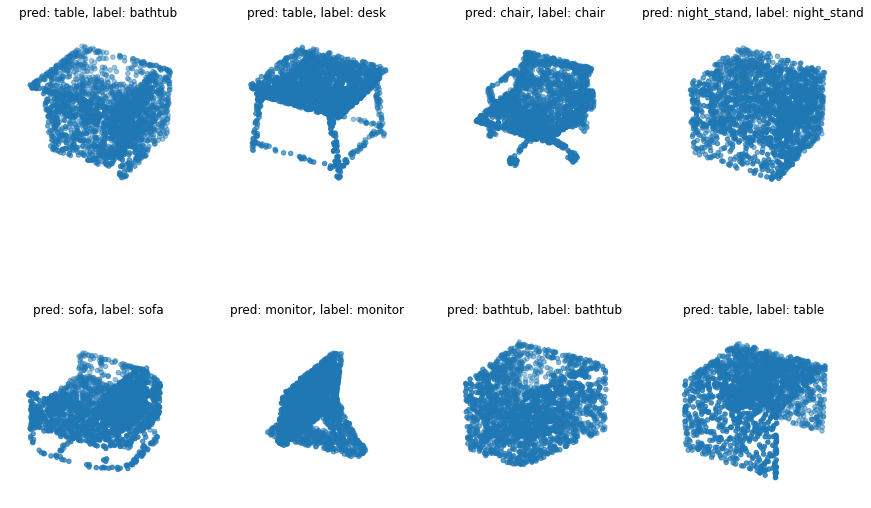

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()


In [ ]:
print(labels)

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:


plot_history(history)



In [ ]:


full_multiclass_report(model,
                       x_test,
                       y_test,
                       le.inverse_transform(np.arange(3)))



In [ ]:
print(preds
     )

NameError: ignored

In [ ]:
from tensorflow import keras
model = keras.models.load_model('path/to/location')


In [ ]:
print()

Normalized confusion matrix


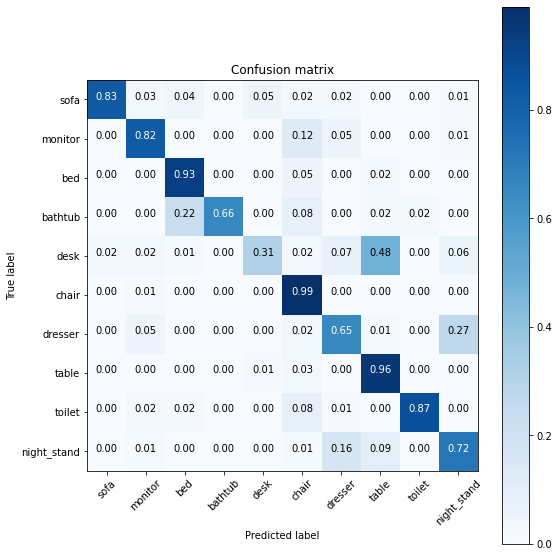

In [ ]:

     
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(correct_labels,predicted_labels);
cm
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,classes, normalize=True)

In [ ]:
print(len(test_dataset))

29


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

NotImplementedError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))
  
# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)


1/1 [==============================] - 0s 227ms/step


In [ ]:
print(concatbatches)

tf.Tensor(
[[[-1.27709016e+01  2.45288299e+01  4.28100000e-01]
  [-1.12149842e+01  9.52982802e+00 -9.07190000e+00]
  [ 1.31552951e+01 -3.11872014e+01  8.09104392e+00]
  ...
  [-1.57500000e+01  3.46428960e+01 -5.32282408e-01]
  [ 3.05979240e+00 -4.66266819e+01  8.42810000e+00]
  [ 1.19791408e+01 -5.24223998e+00 -5.07190000e+00]]

 [[ 3.89287883e+00  7.98350000e+00  1.05558719e+00]
  [-4.46767806e+00 -7.95400000e+00  1.05629365e+01]
  [-2.33329446e+00 -8.01650000e+00  8.86072166e+00]
  ...
  [ 3.64204156e+00 -3.70198940e+00  7.81250000e+00]
  [ 4.73468209e+00  7.98350000e+00  4.87585525e+00]
  [ 5.95862057e+00  3.06870141e+00 -7.25000000e+00]]

 [[-7.21624289e+00 -8.42304268e+00  3.36245000e+00]
  [ 7.57279544e-01  1.28001980e+01  3.75932486e+00]
  [-8.64532329e+00 -9.72968070e+00 -3.57635000e+00]
  ...
  [ 1.09415000e+01 -3.59880214e+00  3.76736046e-01]
  [ 1.09415000e+01  1.14711034e+01  2.62863114e+00]
  [-9.86588349e+00  9.44027625e-01  7.99250000e-01]]

 ...

 [[-2.10559715e+01  2.2

In [ ]:
classes=list(CLASS_MAP.values())

In [ ]:
print(classes)

['toilet', 'monitor', 'table', 'chair', 'night_stand', 'dresser', 'desk', 'bed', 'bathtub', 'sofa']


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'